#Predicting Cab Booking Cancellations

###Notebook by [Abhishek Sharma](http://github.com/numb3r33/)
####Data hosted at [Kaggle](https://inclass.kaggle.com/c/predicting-cab-booking-cancellations/data)

##Table of contents

1. [Introduction](#Introduction)

2. [Required libraries](#Required-libraries)

3. [Step 1: Answering the question](#Step-1:-Answering-the-question)

4. [Step 2: Checking the data](#Step-2:-Checking-the-data)

5. [Step 3: Exploratory analysis](#Step-3:-Exploratory-analysis)

6. [Step 4: Data Preparation](#Step-4:-Data-Preparation)

7. [Step 5: Feature Extraction](#Step-5:-Feature-Extraction)

8. [Step 6: Fitting Model](#Step-6:-Fitting-Model)
    - [Validation](#Validation)
    - [Learning Curves](#Learning-Curves)

9. [Step 7: Performance on Test Set](#Step-7:-Performance-on-test-set)

10. [Step 8: Model Training on full dataset](#Step-8:-Model-Training-on-full-dataset)

11. [Step 9: Prepare Submission](#Step-9:-Prepare-Submission)

12. [Further improvements](#Further-Improvements)

##Introduction

[[ go back to the top ]](#Table-of-contents)

The business problem tackled here is trying to improve customer service for [YourCabs](#http://www.yourcabs.com/), a cab company in Bangalore. The problem of interest is booking cancellations by the company due to unavailability of a car. The challenge is that cancellations can occur very close to the trip start time, thereby causing passengers inconvenience.

###Competition Goal

The goal of the competition is to create a predictive model for classifying new bookings as to whether they will eventually get cancelled due to car unavailability. This is a classification task that includes misclassification costs. The winning entry will be the one with the lowest **average-cost-per-booking.**

Participants need to upload their classifications (0=no cancellation or 1=cancellation), and the system will compute the average-cost-per-booking based on these classifications.

##Required libraries

[[ go back to the top ]](#Table-of-contents)

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn

`conda` may ask you to update some of them if you don't have the most recent version. Allow it to do so.

##Step 1: Answering the question

[[ go back to the top ]](#Table-of-contents)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task.

>Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

The goal of the competition is to create a predictive model for classifying new bookings as to whether they will eventually get cancelled due to car unavailability, so this is a classification task.

>Did you define the metric for success before beginning?

Let's do that now. Since we're taking into account penalties for misclassification, we can use [Weighted Mean Absolute Error](https://www.kaggle.com/wiki/WeightedMeanAbsoluteError)

>Did you understand the context for the question and the scientific or business application?

The business problem tackled here is trying to improve customer service for YourCabs.com, a cab company in Bangalore. The problem of interest is booking cancellations by the company due to unavailability of a car. The challenge is that cancellations can occur very close to the trip start time, thereby causing passengers inconvenience.

>Did you record the experimental design?

The cab bookings data are made available through a collaboration between Prof. Galit Shmueli at the Indian School of Business and YourCabs co-founder Mr. Rajath Kedilaya and IDRC managing partner, Mr. Amit Batra.

>Did you consider whether the question could be answered with the available data?

The data set we currently have is only for three types of *Iris* flowers. The model built off of this data set will only work for those *Iris* flowers, so we will need more data to create a general flower classifier.

##Step 2: Checking the data

[[ go back to the top ]](#Table-of-contents)

The next step is to look at the data we're working with.

Generally, we're looking to answer the following questions:

* Is there anything wrong with the data?
* Are there any quirks with the data?
* Do I need to fix or remove any of the data?

Let's start by reading the data into a pandas DataFrame.

##Data fields

* id - booking *ID*
* user_id - the *ID* of the customer (based on mobile number)
* vehicle_model_id - vehicle model type.
* package_id - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs &   100kms, 5=5hrs & 50kms, 6=3hrs &     30kms, 7=12hrs & 120kms)
* travel_type_id - type of travel (1=long distance, 2= point to point, 3= hourly rental).
* from_area_id - unique identifier of area. Applicable only for point-to-point travel and packages
* to_area_id - unique identifier of area. Applicable only for point-to-point travel
* from_city_id - unique identifier of city
* to_city_id - unique identifier of city (only for intercity)
* from_date - time stamp of requested trip start
* to_date - time stamp of trip end
* online_booking - if booking was done on desktop website
* mobile_site_booking - if booking was done on mobile website
* booking_created - time stamp of booking
* from_lat - latitude of from area
* from_long -  longitude of from area
* to_lat - latitude of to area
* to_long - longitude of to area
* Car_Cancellation (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of   a car.
* Cost_of_error (available only in training data) - the cost incurred if the booking is misclassified. The cost of misclassifying an uncancelled booking as a cancelled booking (cost=1 unit). The cost associated with misclassifying a cancelled booking as uncancelled, This cost is a function of how close the cancellation occurs relative to the trip start time. The closer the trip, the higher the cost. Cancellations occurring less than 15 minutes prior to the trip start incur a fixed penalty of 100 units.

In [1]:
import pandas as pd

In [2]:
cars_cancel_train = pd.read_csv('./data/Kaggle_YourCabs_training.csv')
cars_cancel_train.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83,448,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1
1,132513,21413,12,NaN,2,1010,540,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1
2,132514,22178,12,NaN,2,1301,1034,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1
3,132515,13034,12,NaN,2,768,398,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1
4,132517,22180,12,NaN,2,1365,849,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1


**As you can see there are various columns with missing values and some columns which need to be converted to date-time.**

In [3]:
# convert from_date column to date-time
# Note: when we try to convert NaN to date-time, it gets converted to NaT( Not a timestamp )

cars_cancel_train['from_date'] = pd.to_datetime(cars_cancel_train['from_date'])

In [4]:
# convert to_date column to date-time
cars_cancel_train['to_date'] = pd.to_datetime(cars_cancel_train['to_date'])

In [5]:
# convert booking_created column to date-time
cars_cancel_train['booking_created'] = pd.to_datetime(cars_cancel_train['booking_created'])

Next thing, we could do is to print out the summary statistics about the dataset

In [6]:
cars_cancel_train.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
count,43431.000000,43431.000000,43431.00000,7550.000000,43431.000000,43343.000000,34293.000000,16345.000000,1588.000000,43431.000000,43431.000000,43338.000000,43338.000000,34293.000000,34293.000000,43431.000000,43431.000000
mean,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595,0.072114,8.000509
std,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045,0.258680,25.350698
min,132512.000000,16.000000,1.00000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930,0.000000,0.150000
25%,145778.000000,24614.000000,12.00000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,0.000000,0.000000,12.926450,77.593661,12.951850,77.582030,0.000000,1.000000
50%,159248.000000,31627.000000,12.00000,2.000000,2.000000,590.000000,541.000000,15.000000,49.000000,0.000000,0.000000,12.968887,77.635750,12.982750,77.645030,0.000000,1.000000
75%,172578.500000,39167.000000,24.00000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880,0.000000,1.000000
max,185941.000000,48730.000000,91.00000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420,1.000000,100.000000


**We can see that many of the columns are missing values like package_id, to_area_id etc.**

Let's also set id to be the index of the dataset

In [7]:
cars_cancel_train.set_index('id', inplace=True)

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

In [9]:
# lets find out the class balance
cars_cancel_train.Car_Cancellation.value_counts()

0    40299
1     3132
dtype: int64

##Step-3:-Exploratory-analysis

[[ go back to the top ]](#Table-of-contents)


** Major class imbalance, very few cancellations as compared to large amount of non-cancellations. **

In [10]:
# Lets see the distribution of package_id
cars_cancel_train.package_id.value_counts()

1    3503
2    2651
6     502
4     412
3     375
7     101
5       6
dtype: int64

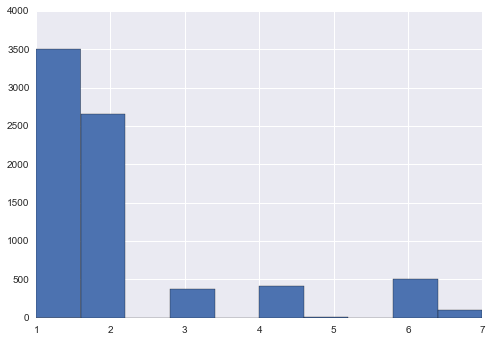

In [11]:
cars_cancel_train.package_id.hist();

** Most of the packages that people opt for are for a journey of 4hrs and around 40kms, followed by 8hrs and 80kms.**

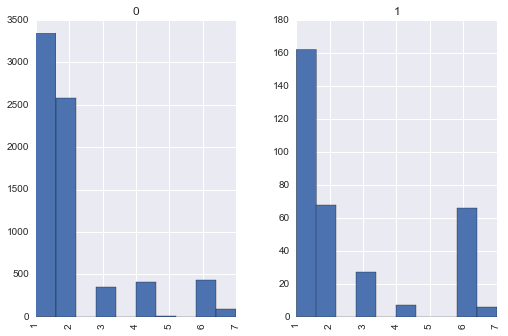

In [12]:
# Let's see whether package type affect car cancellations
cars_cancel_train.hist(column='package_id', by='Car_Cancellation');

**As you can see most of the times 1st package ( 4hrs & 40kms ) gets cancelled followed by packages ( 3hrs & 30kms ) and ( 8hrs & 80kms ).**

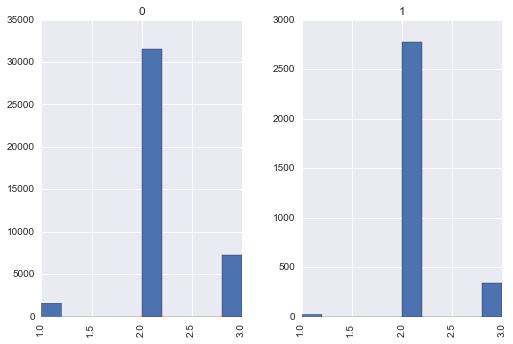

In [13]:
# Lets take a look at travel_type variable
cars_cancel_train.hist(column='travel_type_id', by='Car_Cancellation');

** Not surprisingly, most people rent car from point to point travel and around ( 1 / 10 )th of these bookings get cancelled. **

In [14]:
# Lets take a look at from_area_id variable and see if it has any relation with car cancellation.
g = cars_cancel_train.groupby(['from_area_id', 'Car_Cancellation']).size().unstack(1)

In [15]:
g.head()

Car_Cancellation,0,1
from_area_id,,
2,27,4
6,7,NaN
15,6,NaN
16,5,NaN
17,2,NaN


In [16]:
g['percent_cancelled'] = (g[1] / (g[1] + g[0])) * 100.

In [17]:
g.percent_cancelled.order(ascending=False).iloc[:20]

from_area_id
130     80.000000
1148    66.666667
1174    66.666667
630     66.666667
176     52.830189
1381    50.000000
1160    50.000000
1100    50.000000
1385    50.000000
1276    45.454545
211     44.444444
1372    40.000000
356     40.000000
987     40.000000
626     34.375000
1258    33.333333
34      33.333333
326     33.333333
177     33.333333
833     33.333333
Name: percent_cancelled, dtype: float64

**So as you can see there are certain areas ( from area ) for which more than 50% of the bookings were cancelled.**

In [18]:
to = cars_cancel_train.groupby(['to_area_id', 'Car_Cancellation']).size().unstack(1)

In [19]:
to.head()

Car_Cancellation,0,1
to_area_id,,
2,4,NaN
6,2,NaN
15,3,2
16,3,1
17,1,NaN


In [20]:
to['percent_cancelled'] = (to[1] / (to[1] + to[0])) * 100.

In [21]:
to.percent_cancelled.order(ascending=False).iloc[:20]

to_area_id
1247    75.000000
677     66.666667
355     66.666667
1218    60.000000
845     60.000000
1310    50.000000
1311    50.000000
1387    50.000000
1197    50.000000
1225    50.000000
1193    50.000000
1235    50.000000
598     50.000000
1357    50.000000
1336    50.000000
118     50.000000
122     41.463415
626     40.000000
520     40.000000
525     40.000000
Name: percent_cancelled, dtype: float64

In [22]:
from_to = cars_cancel_train.groupby(['from_area_id', 'to_area_id', 'Car_Cancellation']).size()

In [23]:
f_t = from_to.unstack(2)

In [24]:
f_t.head()

Car_Cancellation          0   1
from_area_id to_area_id        
2            222          1 NaN
             393         12 NaN
             452          1 NaN
             455        NaN   1
             572        NaN   1

In [25]:
f_t['percent_cancelled'] = (f_t[1] / (f_t[0] + f_t[1])) * 100.

In [26]:
f_t.percent_cancelled.order(ascending=False).iloc[:20]

from_area_id  to_area_id
626           122           90.909091
1349          1052          83.333333
1330          176           80.000000
1052          1349          78.571429
625           452           75.000000
1296          793           75.000000
1365          293           75.000000
1285          61            70.588235
122           626           70.000000
176           136           66.666667
1068          352           66.666667
264           585           66.666667
1384          160           66.666667
839           585           66.666667
571           396           66.666667
83            176           66.666667
1095          25            66.666667
363           1068          66.666667
542           1237          66.666667
541           83            66.666667
Name: percent_cancelled, dtype: float64

** So there are some routes for which the cancellation rate is pretty high, e.g. from area-626 to-122 almost 90% of the bookings were cancelled **

In [27]:
import numpy as np

In [28]:
# Lets see if online or mobile booking has any effect on cancellation
pd.pivot_table(cars_cancel_train[['online_booking', 'mobile_site_booking', 'Car_Cancellation']]
              , values='Car_Cancellation', index=['online_booking', 'mobile_site_booking'], aggfunc= np.count_nonzero)

online_booking  mobile_site_booking
0               0                       940
                1                       289
1               0                      1903
Name: Car_Cancellation, dtype: int64

**So most of the cancellations are of orders that were booked online.**

In [29]:
booking_diff = cars_cancel_train[['from_date', 'to_date', 'booking_created', 'Car_Cancellation']]

In [30]:
booking_diff.loc[:, 'difference'] = booking_diff.loc[:, ('from_date')] - booking_diff.loc[:, ('booking_created')]

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
booking_diff.head()

,from_date,to_date,booking_created,Car_Cancellation,difference
id,,,,,
132512,2013-01-01 02:00:00,NaT,2013-01-01 01:39:00,0,00:21:00
132513,2013-01-01 09:00:00,NaT,2013-01-01 02:25:00,0,06:35:00
132514,2013-01-01 03:30:00,NaT,2013-01-01 03:08:00,0,00:22:00
132515,2013-01-01 05:45:00,NaT,2013-01-01 04:39:00,0,01:06:00
132517,2013-01-01 09:00:00,NaT,2013-01-01 07:53:00,0,01:07:00


In [32]:
def convert_to_days(x):
    seconds = int(x / (1e9))
    days = seconds / ( 24. * 60 * 60 )
    return days

booking_diff.loc[:, 'diff_in_days'] = booking_diff.difference.map(convert_to_days)

In [33]:
booking_diff.head()

,from_date,to_date,booking_created,Car_Cancellation,difference,diff_in_days
id,,,,,,
132512,2013-01-01 02:00:00,NaT,2013-01-01 01:39:00,0,00:21:00,0.014583
132513,2013-01-01 09:00:00,NaT,2013-01-01 02:25:00,0,06:35:00,0.274306
132514,2013-01-01 03:30:00,NaT,2013-01-01 03:08:00,0,00:22:00,0.015278
132515,2013-01-01 05:45:00,NaT,2013-01-01 04:39:00,0,01:06:00,0.045833
132517,2013-01-01 09:00:00,NaT,2013-01-01 07:53:00,0,01:07:00,0.046528


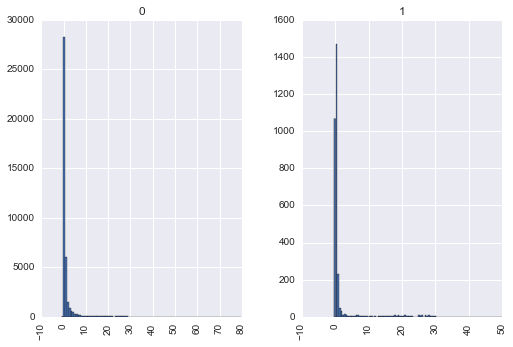

In [34]:
booking_diff.hist(column='diff_in_days', by='Car_Cancellation', bins=100);

** There seems to be no relation between number of days between date of booking and trip's start date with cancellation.
Generally people tend to cancel their booking 5 days prior to their trip's start date which is not unusual **

##Step-4:-Data-Preparation

[[ go back to the top ]](#Table-of-contents)


** Following features will be considered for analysis **

* vehicle_model_id
* package_id
* travel_type_id
* from_area_id
* to_area_id
* from_city_id
* to_city_id
* days_before_booking
* online_booking
* mobile_site_booking
* from_month
* from_weekday
* booking_month
* booking_weekday


** Many of them have missing values which have to be dealt accordingly **

In [100]:
cars_cancel_train.columns

Index([u'user_id', u'vehicle_model_id', u'package_id', u'travel_type_id',
       u'from_area_id', u'to_area_id', u'from_city_id', u'to_city_id',
       u'from_date', u'to_date', u'online_booking', u'mobile_site_booking',
       u'booking_created', u'from_lat', u'from_long', u'to_lat', u'to_long',
       u'Car_Cancellation', u'Cost_of_error', u'days_before_booking'],
      dtype='object')

In [101]:
cars_cancel_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43431 entries, 132512 to 185941
Data columns (total 20 columns):
user_id                43431 non-null int64
vehicle_model_id       43431 non-null int64
package_id             7550 non-null float64
travel_type_id         43431 non-null int64
from_area_id           43343 non-null float64
to_area_id             34293 non-null float64
from_city_id           16345 non-null float64
to_city_id             1588 non-null float64
from_date              43431 non-null datetime64[ns]
to_date                25541 non-null datetime64[ns]
online_booking         43431 non-null int64
mobile_site_booking    43431 non-null int64
booking_created        43431 non-null datetime64[ns]
from_lat               43338 non-null float64
from_long              43338 non-null float64
to_lat                 34293 non-null float64
to_long                34293 non-null float64
Car_Cancellation       43431 non-null int64
Cost_of_error          43431 non-null float64
days

In [102]:
cars_cancel_train.loc[:, 'from_month'] = cars_cancel_train.from_date.dt.month
cars_cancel_train.loc[:, 'from_weekday'] = cars_cancel_train.from_date.dt.weekday

cars_cancel_train.loc[:, 'booking_month'] = cars_cancel_train.booking_created.dt.month
cars_cancel_train.loc[:, 'booking_weekday'] = cars_cancel_train.booking_created.dt.weekday

In [35]:
cars_cancel_train.loc[:, 'days_before_booking'] = booking_diff['diff_in_days']

In [326]:
features_cols = ['vehicle_model_id', 'travel_type_id', 'from_area_id',
                 'to_area_id','from_month', 'from_weekday',
                 'days_before_booking', 'online_booking', 'mobile_site_booking',
                 'booking_month', 'booking_weekday']

In [327]:
features = cars_cancel_train[features_cols]
y = cars_cancel_train.Car_Cancellation

In [328]:
# Add a new level ( -9999 ) for missing values
features.from_area_id.fillna(-9999, inplace=True)
features.to_area_id.fillna(-9999, inplace=True)

##Step-5:-Feature-Extraction

[[ go back to the top ]](#Table-of-contents)


In [329]:
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(y, n_iter=2, test_size=0.3)

In [330]:
train_index, test_index = next(iter(sss))

X_train = features.iloc[train_index]
y_train = y.iloc[train_index]

X_test = features.iloc[test_index]
y_test = y.iloc[test_index]

In [331]:
print 'Shape of training and test dataset %s %s ' %(X_train.shape, X_test.shape)

Shape of training and test dataset (30401, 11) (13030, 11) 


In [332]:
## Take a sample from the training data to do feature selection
sss = StratifiedShuffleSplit(y_train, n_iter=2, test_size=.2)

In [333]:
train_index, test_index = next(iter(sss))

X_train_features = X_train.iloc[test_index]
y_train_features = y_train.iloc[test_index]

X_train_rest = X_train.iloc[train_index]
y_train_rest = y_train.iloc[train_index]

In [334]:
print 'Shape of the training data used for feature selection %s and rest of the dataset %s ' %(X_train_features.shape, X_train_rest.shape)

Shape of the training data used for feature selection (6081, 11) and rest of the dataset (24320, 11) 


In [335]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV

logreg = LogisticRegression()
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(y_train_features, 5), scoring='roc_auc')

rfecv.fit(X_train_features, y_train_features)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
   estimator_params=None, scoring='roc_auc', step=1, verbose=0)

In [336]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 11


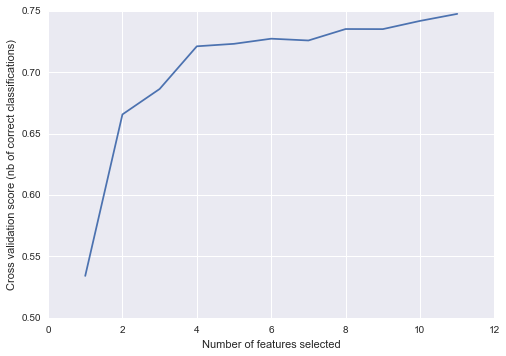

In [337]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [338]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [339]:
features_cols_np = np.array(features_cols)

In [340]:
features_to_consider = features_cols_np[rfecv.support_]

In [341]:
print 'Selected features are %s ' %(features_to_consider)

Selected features are ['vehicle_model_id' 'travel_type_id' 'from_area_id' 'to_area_id'
 'from_month' 'from_weekday' 'days_before_booking' 'online_booking'
 'mobile_site_booking' 'booking_month' 'booking_weekday'] 


##Step-6:-Fitting-Model

[[ go back to the top ]](#Table-of-contents)


In [342]:
Xt = X_train_rest[features_cols]
yt = y_train_rest

In [343]:
from sklearn.cross_validation import train_test_split

Xtr, Xv, ytr, yv = train_test_split(Xt, yt, test_size=0.3)

In [406]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

logreg = LogisticRegression(C=13., penalty='l1', class_weight='auto')
etr = ExtraTreesClassifier(n_estimators=75, class_weight='auto')
knn = KNeighborsClassifier(weights='distance', n_neighbors=10)
rf = RandomForestClassifier(n_estimators=50)
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)

In [407]:
from sklearn.cross_validation import cross_val_score
sss = StratifiedShuffleSplit(ytr, 5, test_size=.2)

cv_scores = cross_val_score(gbc, Xtr, ytr, scoring='roc_auc', cv=sss)

In [408]:
print 'cross validation scores are %s ' %(cv_scores)

cross validation scores are [ 0.86118732  0.87140339  0.87477837  0.87601177  0.87260335] 


In [409]:
print 'Mean cross validation score %s ' %(cv_scores.mean())

Mean cross validation score 0.871196841017 


In [410]:
print 'Standard deviation in cv scores %s ' %(cv_scores.std())

Standard deviation in cv scores 0.00525780070108 


##Validation

[[ go back to the top ]](#Table-of-contents)


In [290]:
from sklearn.learning_curve import validation_curve

In [294]:
C = np.linspace(0.1, 50, 5)
val_train, val_test = validation_curve(LogisticRegression(penalty='l1', class_weight='auto'),
                                       Xtr, ytr, 'C', C, cv=5, scoring='roc_auc')

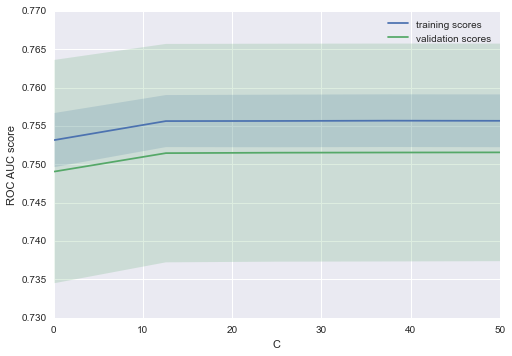

In [296]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(C, val_train, label='training scores')
plot_with_err(C, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC score')
plt.legend();

##Learning-Curves

[[ go back to the top ]](#Table-of-contents)


In [301]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(C=13):
    train_sizes = np.linspace(0.05, 1, 10)
    N_train, val_train, val_test = learning_curve(LogisticRegression(C=C, penalty='l2', class_weight='auto'),
                                                  Xtr, ytr, train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('ROC AUC Score')
    plt.legend()

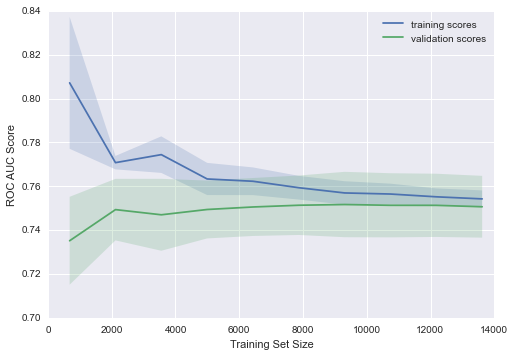

In [302]:
plot_learning_curve()

##Step-7:-Performance-on-test-set

[[ go back to the top ]](#Table-of-contents)


In [411]:
# knn.fit(Xtr, ytr)
# logreg.fit(Xtr, ytr)
gbc.fit(Xtr, ytr)
# rf.fit(Xtr, ytr)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [436]:
# ytest_pred_knn = knn.predict(Xv)
# ytest_pred_logreg = logreg.predict_proba(Xv)[:, 1]
ytest_pred_gbc = gbc.predict_proba(Xv)[:, 1]
ytest_preds_threshold = [1 if pred > 0.10 else 0 for pred in ytest_pred_gbc]
# ytest_pred_rf = rf.predict(Xv)

In [437]:
from sklearn.metrics import roc_auc_score

In [438]:
print 'ROC AUC score on the test dataset ', roc_auc_score(yv, ytest_preds_threshold)

ROC AUC score on the test dataset  0.746771205593


##Step-8:-Model-Training-on-full-dataset

[[ go back to the top ]](#Table-of-contents)


In [439]:
final_features = features[features_cols]

In [440]:
# logreg.fit(final_features, y)
# knn.fit(final_features, y)
gbc.fit(final_features, y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

##Step-9:-Prepare-Submission

[[ go back to the top ]](#Table-of-contents)


In [441]:
cars_cancel_test = pd.read_csv('./data/Kaggle_YourCabs_score.csv', index_col='id')
cars_cancel_test.head()

,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Unnamed: 18,Unnamed: 19
id,,,,,,,,,,,,,,,,,,,
132516,22179,12,NaN,2,1096,393,NaN,NaN,1/1/2013 9:30,NaN,0,0,1/1/2013 7:51,12.965190,77.719320,13.19956,77.70688,NaN,NaN
132529,22187,65,NaN,2,1061,393,NaN,NaN,1/2/2013 1:00,NaN,0,0,1/1/2013 12:11,12.924878,77.566255,13.19956,77.70688,NaN,NaN
132532,23180,12,NaN,2,1192,353,NaN,NaN,1/2/2013 4:30,NaN,0,0,1/1/2013 12:22,12.976770,77.572700,13.03241,77.59914,NaN,NaN
132547,30849,12,NaN,2,515,849,NaN,NaN,1/1/2013 20:15,NaN,0,0,1/1/2013 16:51,12.978960,77.673450,12.95434,77.60072,NaN,NaN
132548,22198,12,NaN,2,83,463,NaN,NaN,1/3/2013 0:30,NaN,0,0,1/1/2013 17:04,12.924150,77.672290,12.96037,77.58132,NaN,NaN


In [442]:
cars_cancel_test['from_date'] = pd.to_datetime(cars_cancel_test['from_date'])
cars_cancel_test['to_date'] = pd.to_datetime(cars_cancel_test['to_date'])
cars_cancel_test['booking_created'] = pd.to_datetime(cars_cancel_test['booking_created'])

In [443]:
cars_cancel_test.loc[:, 'difference'] = cars_cancel_test.loc[:, ('from_date')] - cars_cancel_test.loc[:, ('booking_created')]

In [444]:
cars_cancel_test.loc[:, 'from_month'] = cars_cancel_test.from_date.dt.month
cars_cancel_test.loc[:, 'from_weekday'] = cars_cancel_test.from_date.dt.weekday

cars_cancel_test.loc[:, 'booking_month'] = cars_cancel_test.booking_created.dt.month
cars_cancel_test.loc[:, 'booking_weekday'] = cars_cancel_test.booking_created.dt.weekday

In [445]:
cars_cancel_test.loc[:, 'days_before_booking'] = cars_cancel_test.difference.map(convert_to_days)

In [446]:
features_test = cars_cancel_test[features_cols]

In [447]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 132516 to 185942
Data columns (total 11 columns):
vehicle_model_id       10000 non-null int64
travel_type_id         10000 non-null int64
from_area_id           9980 non-null float64
to_area_id             7850 non-null float64
from_month             10000 non-null int64
from_weekday           10000 non-null int64
days_before_booking    10000 non-null float64
online_booking         10000 non-null int64
mobile_site_booking    10000 non-null int64
booking_month          10000 non-null int64
booking_weekday        10000 non-null int64
dtypes: float64(3), int64(8)
memory usage: 937.5 KB


In [448]:
features_test.from_area_id.fillna(-9999, inplace=True)
features_test.to_area_id.fillna(-9999, inplace=True)

In [449]:
# preds_logreg = logreg.predict(features_test)
# preds_knn = knn.predict(features_test)
preds_gbc = gbc.predict_proba(features_test)[:, 1]

In [450]:
preds_threshold = [1 if pred > 0.10 else 0 for pred in preds_gbc]

In [451]:
submission = pd.DataFrame({'id': features_test.index.values, 'Car_Cancellation': preds_threshold})

In [452]:
submission.to_csv('./submissions/GBC_threshold.csv', index=False)

##Further-Improvements

** The above approach would get to you to 2nd place in the leaderboard **
<p>But there is enough room to improve the model. As you can see I did not perform any kind of grid search for hyper-parameter selection, we could further set up a pipeline in which we could search for optimal parameters for Gradient Boosting Classifier.</p>

* Hyper-parameter selection.
* Training Models on different sample of data.
* Ensemble learning ( averaging predictions of different models ).